In [1]:
#pip install yfinance
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#pip pip install keras
#pip install tensorflow
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt

#https://github.com/AnonMrNone/Live_Stock_Market_Forecasting
#https://www.youtube.com/watch?v=5Gm3bWNBoWQ

print('Modulok betöltödtek')
szimbolum = 'TCEHY'
#Adatok letöltése a megadott intervalumra
adatok = yf.download(tickers=szimbolum,period='3y',interval='1d')
type(adatok)
adatok.head()


Modulok betöltödtek
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-08,43.799999,44.349998,43.660000,44.230000,43.873669,1806300
2019-02-11,44.930000,45.209999,44.660000,44.689999,44.329960,2945700
2019-02-12,44.799999,44.950001,44.459999,44.619999,44.260525,2992200
2019-02-13,44.220001,44.380001,43.610001,43.860001,43.506653,3377500
2019-02-14,43.009998,43.250000,42.700001,42.900002,42.554382,5024300


[[43.79999924]
 [44.93000031]
 [44.79999924]
 [44.22000122]
 [43.00999832]
 [42.91999817]
 [42.90000153]
 [43.43999863]
 [43.61999893]
 [44.        ]
 [44.25      ]
 [43.75      ]
 [43.45000076]
 [42.90999985]
 [42.95000076]
 [44.18000031]
 [45.70999908]
 [46.50999832]
 [45.13999939]
 [43.47999954]
 [45.18000031]
 [45.54000092]
 [45.65000153]
 [45.66999817]
 [45.72999954]
 [46.95000076]
 [47.11000061]
 [46.95999908]
 [45.33000183]
 [46.11999893]
 [44.90000153]
 [45.02999878]
 [45.22000122]
 [44.90000153]
 [45.88999939]
 [46.40999985]
 [46.95000076]
 [48.        ]
 [47.83000183]
 [48.34000015]
 [48.34999847]
 [48.84000015]
 [49.56000137]
 [49.77999878]
 [50.59999847]
 [49.50999832]
 [50.11000061]
 [50.45000076]
 [50.29000092]
 [49.70999908]
 [49.97999954]
 [50.04999924]
 [48.81999969]
 [49.15000153]
 [49.81000137]
 [49.40999985]
 [49.31000137]
 [49.31000137]
 [49.47000122]
 [47.47000122]
 [47.95000076]
 [49.09000015]
 [47.36000061]
 [48.20000076]
 [46.65999985]
 [47.00999832]
 [46.50999

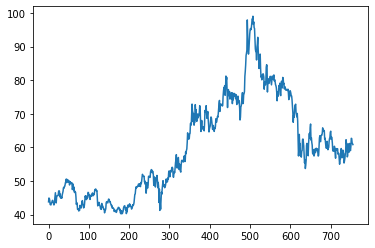

In [2]:
#A nyitási adatok letöltése
nyitar = adatok[['Open']]
#Adatok áttöltése egy listába
ls = nyitar.values
print(ls)
plt.plot(ls)

In [3]:
#Adatok normalizlása, hogy minden adat -1 és 1 közzé essen az adatok között a változás megmaradjon. 
#Ez azért kell, hogy a modell tanulni tudjan, mivel ha az adatok intervallumban mozognak akkor megzavarja a tanulási folyamatott
normalizalt = MinMaxScaler(feature_range=(0,1))
ls_lista = normalizalt.fit_transform(np.array(ls).reshape(-1,1))
print(len(ls_lista), len(ls))
#Megadjuk a proba és a teszt halamazok hosszát
proba_h = int(len(ls_lista)*0.70)
teszt_h = len(ls_lista) - proba_h
proba_h,teszt_h

756 756


(529, 227)

In [4]:
#Kétté vágjuk tanitó és teszt adatokra a nagy listát
ls_proba, ls_teszt = ls_lista[0:proba_h,:], ls_lista[proba_h:len(ls_lista),:1]
len(ls_proba),len(ls_teszt)
#Ez a fügvény azt csinálja, hogy szét válogassa az adathalmazt két részre:proba részre és tesztre.
def gen_ls(adathalmaz,lepes):
    Xproba, Yproba = [], []
    for i in range(len(adathalmaz)-lepes-1):
        a = adathalmaz[i:(i+lepes), 0]
        Xproba.append(a)
        Yproba.append(adathalmaz[i + lepes, 0])
    return np.array(Xproba), np.array(Yproba)


In [5]:
#Feltöltom a proba és teszt adathalamazokat a fügvénnyel
#Ez azt jelenti, hogy 100 adatbol fog egyszer prediktálni, ez lesz a model lépésköze. A modell 100 rekordott fog egynek nézni
idokoz = 50
X_proba, y_proba = gen_ls(ls_proba,idokoz)
X_teszt, y_teszt = gen_ls(ls_teszt,idokoz)
print(X_proba.shape,y_proba.shape)
print(X_teszt.shape, y_teszt.shape)

(478, 50) (478,)
(176, 50) (176,)


In [6]:
#az adatokat megfelelo formaba alakitjuk
X_proba = X_proba.reshape(X_proba.shape[0],X_proba.shape[1] , 1)
X_teszt = X_teszt.reshape(X_teszt.shape[0],X_teszt.shape[1] , 1)


In [7]:
#Modell létrehozása
model = Sequential()
#Első LSTM háló létrehozása, aminek az indupt adata a X_proba
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_proba.shape[1],1)))
#Kiszűröm az adatok 0.2%kát a modellel(pontosítok)
model.add(Dropout(0.2))
#2. LSTM haló hozzáadása
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
#3. LSTM haló llétrehozása az elözö paraméterek szerint
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#4. LSTM haló
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

Epoch 1/100
8/8 [==============================] - 17s 736ms/step - loss: 0.0636 - val_loss: 0.0221
Epoch 2/100
8/8 [==============================] - 2s 316ms/step - loss: 0.0195 - val_loss: 0.0060
Epoch 3/100
8/8 [==============================] - 2s 312ms/step - loss: 0.0112 - val_loss: 0.0067
Epoch 4/100
8/8 [==============================] - 2s 314ms/step - loss: 0.0105 - val_loss: 0.0246
Epoch 5/100
8/8 [==============================] - 3s 320ms/step - loss: 0.0087 - val_loss: 0.0055
Epoch 6/100
8/8 [==============================] - 2s 320ms/step - loss: 0.0086 - val_loss: 0.0161
Epoch 7/100
8/8 [==============================] - 2s 313ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 8/100
8/8 [==============================] - 2s 302ms/step - loss: 0.0073 - val_loss: 0.0119
Epoch 9/100
8/8 [==============================] - 2s 239ms/step - loss: 0.0070 - val_loss: 0.0091
Epoch 10/100
8/8 [==============================] - 2s 211ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 11

8/8 [==============================] - 2s 294ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 84/100
8/8 [==============================] - 2s 283ms/step - loss: 0.0027 - val_loss: 0.0058
Epoch 85/100
8/8 [==============================] - 2s 288ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 86/100
8/8 [==============================] - 2s 270ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 87/100
8/8 [==============================] - 2s 243ms/step - loss: 0.0031 - val_loss: 0.0055
Epoch 88/100
8/8 [==============================] - 2s 262ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 89/100
8/8 [==============================] - 2s 308ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 90/100
8/8 [==============================] - 2s 299ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 91/100
8/8 [==============================] - 2s 298ms/step - loss: 0.0032 - val_loss: 0.0062
Epoch 92/100
8/8 [==============================] - 2s 198ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 93/100


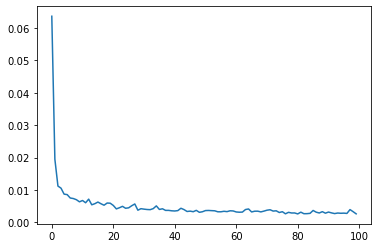

In [8]:
#Adatok tanulása
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_proba,y_proba,validation_data=(X_teszt,y_teszt),epochs=100,batch_size=64)

#Tanulási eredmény vizsgálata
loss = model.history.history['loss']
plt.plot(loss)

In [9]:
#Elörejelzés a proba és teszt adatokra
proba_predict = model.predict(X_proba)
teszt_predict = model.predict(X_teszt)

#Vissza konvertáljuk a normalizált adatokat, a szebb vizuaizációért
proba_predict = normalizalt.inverse_transform(proba_predict)
teszt_predict = normalizalt.inverse_transform(teszt_predict)

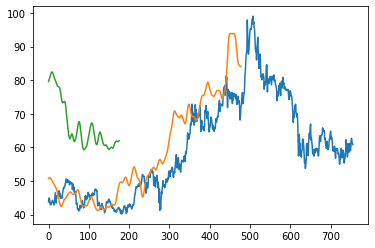

In [10]:
#A proba és teszt elörejelzés eredmenyei
plt.plot(normalizalt.inverse_transform(ls_lista))
plt.plot(proba_predict)
plt.plot(teszt_predict)

227


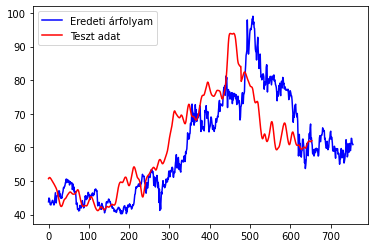

In [11]:
test = np.vstack((proba_predict,teszt_predict))
plt.plot(normalizalt.inverse_transform(ls_lista),color='blue',label='Eredeti árfolyam')
plt.plot(test,color='red',label='Teszt adat')
plt.legend(loc='best')
print(len(ls_teszt))

In [12]:
#Elörejelezni a legutolso 100adatot. Ha itt többet akarunk akkor lehet, de a While ciklusnál szintén kell
elorejelzes = ls_teszt[len(ls_teszt)-100:]
elorejelzes = elorejelzes.reshape(1,-1)
ideglenes = list(elorejelzes)
elorejelzes.shape
#Konvertálás listába
ideglenes = ideglenes[0].tolist()
print(len(ideglenes))

100


In [18]:
#Elörejelezni a következő 30 adatott, 100adatbol
#It's stuck here all the time 
lst_er=[]
ls_hossza=99
i=0
napok=50
while(i<napok):
    if(len(ideglenes)>50):
        elorejelzes = np.array(ideglenes[1:])
        elorejelzes=elorejelzes.reshape(1,-1)
        elorejelzes = elorejelzes.reshape((1, ls_hossza, 1))
        yhat = model.predict(elorejelzes, verbose=0)
        ideglenes.extend(yhat[0].tolist())
        ideglenes = ideglenes[1:]
        lst_er.extend(yhat.tolist())
        i=i+1
    else:
        elorejelzes = elorejelzes.reshape((1, ls_hossza,1))
        yhat = model.predict(elorejelzes, verbose=0)
        ideglenes.extend(yhat[0].tolist())
        lst_er.extend(yhat.tolist())
        i=i+1
print(len(lst_er))

50


ValueError: x and y must have same first dimension, but have shapes (0,) and (50, 1)

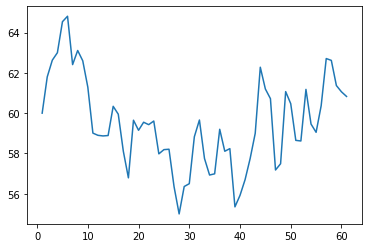

In [19]:
#Uj diagram kiszitése az adatok megjelenitésehez, így lehet majd össze csusztatni az adatokat
plot_new=np.arange(1,62)
plot_pred=np.arange(62,len(lst_er)+1)

plt.plot(plot_new, normalizalt.inverse_transform(ls_lista[len(ls_lista)-61:]),label='Eredeti adatok')
plt.plot(plot_pred, normalizalt.inverse_transform(lst_er),label='Elörejelzett adatok')
plt.legend(loc='best')


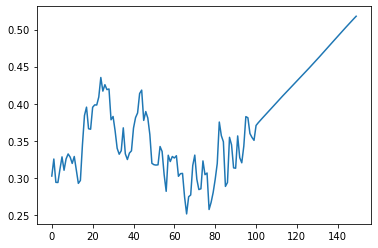

In [20]:
#A elörejelzett és az eredeti adatok össze csusztatása
uj_df = ls_lista.tolist()
uj_df.extend(lst_er)
plt.plot(uj_df[len(ls_lista)-100:])


[[62.00764923]
 [62.21124561]
 [62.39825223]
 [62.57547884]
 [62.74911484]
 [62.9231013 ]
 [63.09932906]
 [63.277346  ]
 [63.45640209]
 [63.63556858]
 [63.8140131 ]
 [63.99103118]
 [64.16668065]
 [64.34094049]
 [64.51377214]
 [64.68507046]
 [64.85529107]
 [65.0250438 ]
 [65.19490167]
 [65.36472449]
 [65.53438258]
 [65.70433333]
 [65.87475371]
 [66.04565424]
 [66.21701039]
 [66.38941972]
 [66.56263865]
 [66.73689674]
 [66.91214667]
 [67.08879499]
 [67.26631601]
 [67.44492174]
 [67.62455962]
 [67.8049668 ]
 [67.9859505 ]
 [68.16717429]
 [68.34917087]
 [68.53143206]
 [68.71361965]
 [68.89560922]
 [69.07694165]
 [69.25764498]
 [69.43761056]
 [69.61644936]
 [69.79422446]
 [69.97117946]
 [70.14651175]
 [70.32027742]
 [70.49243791]
 [70.66294065]]
50


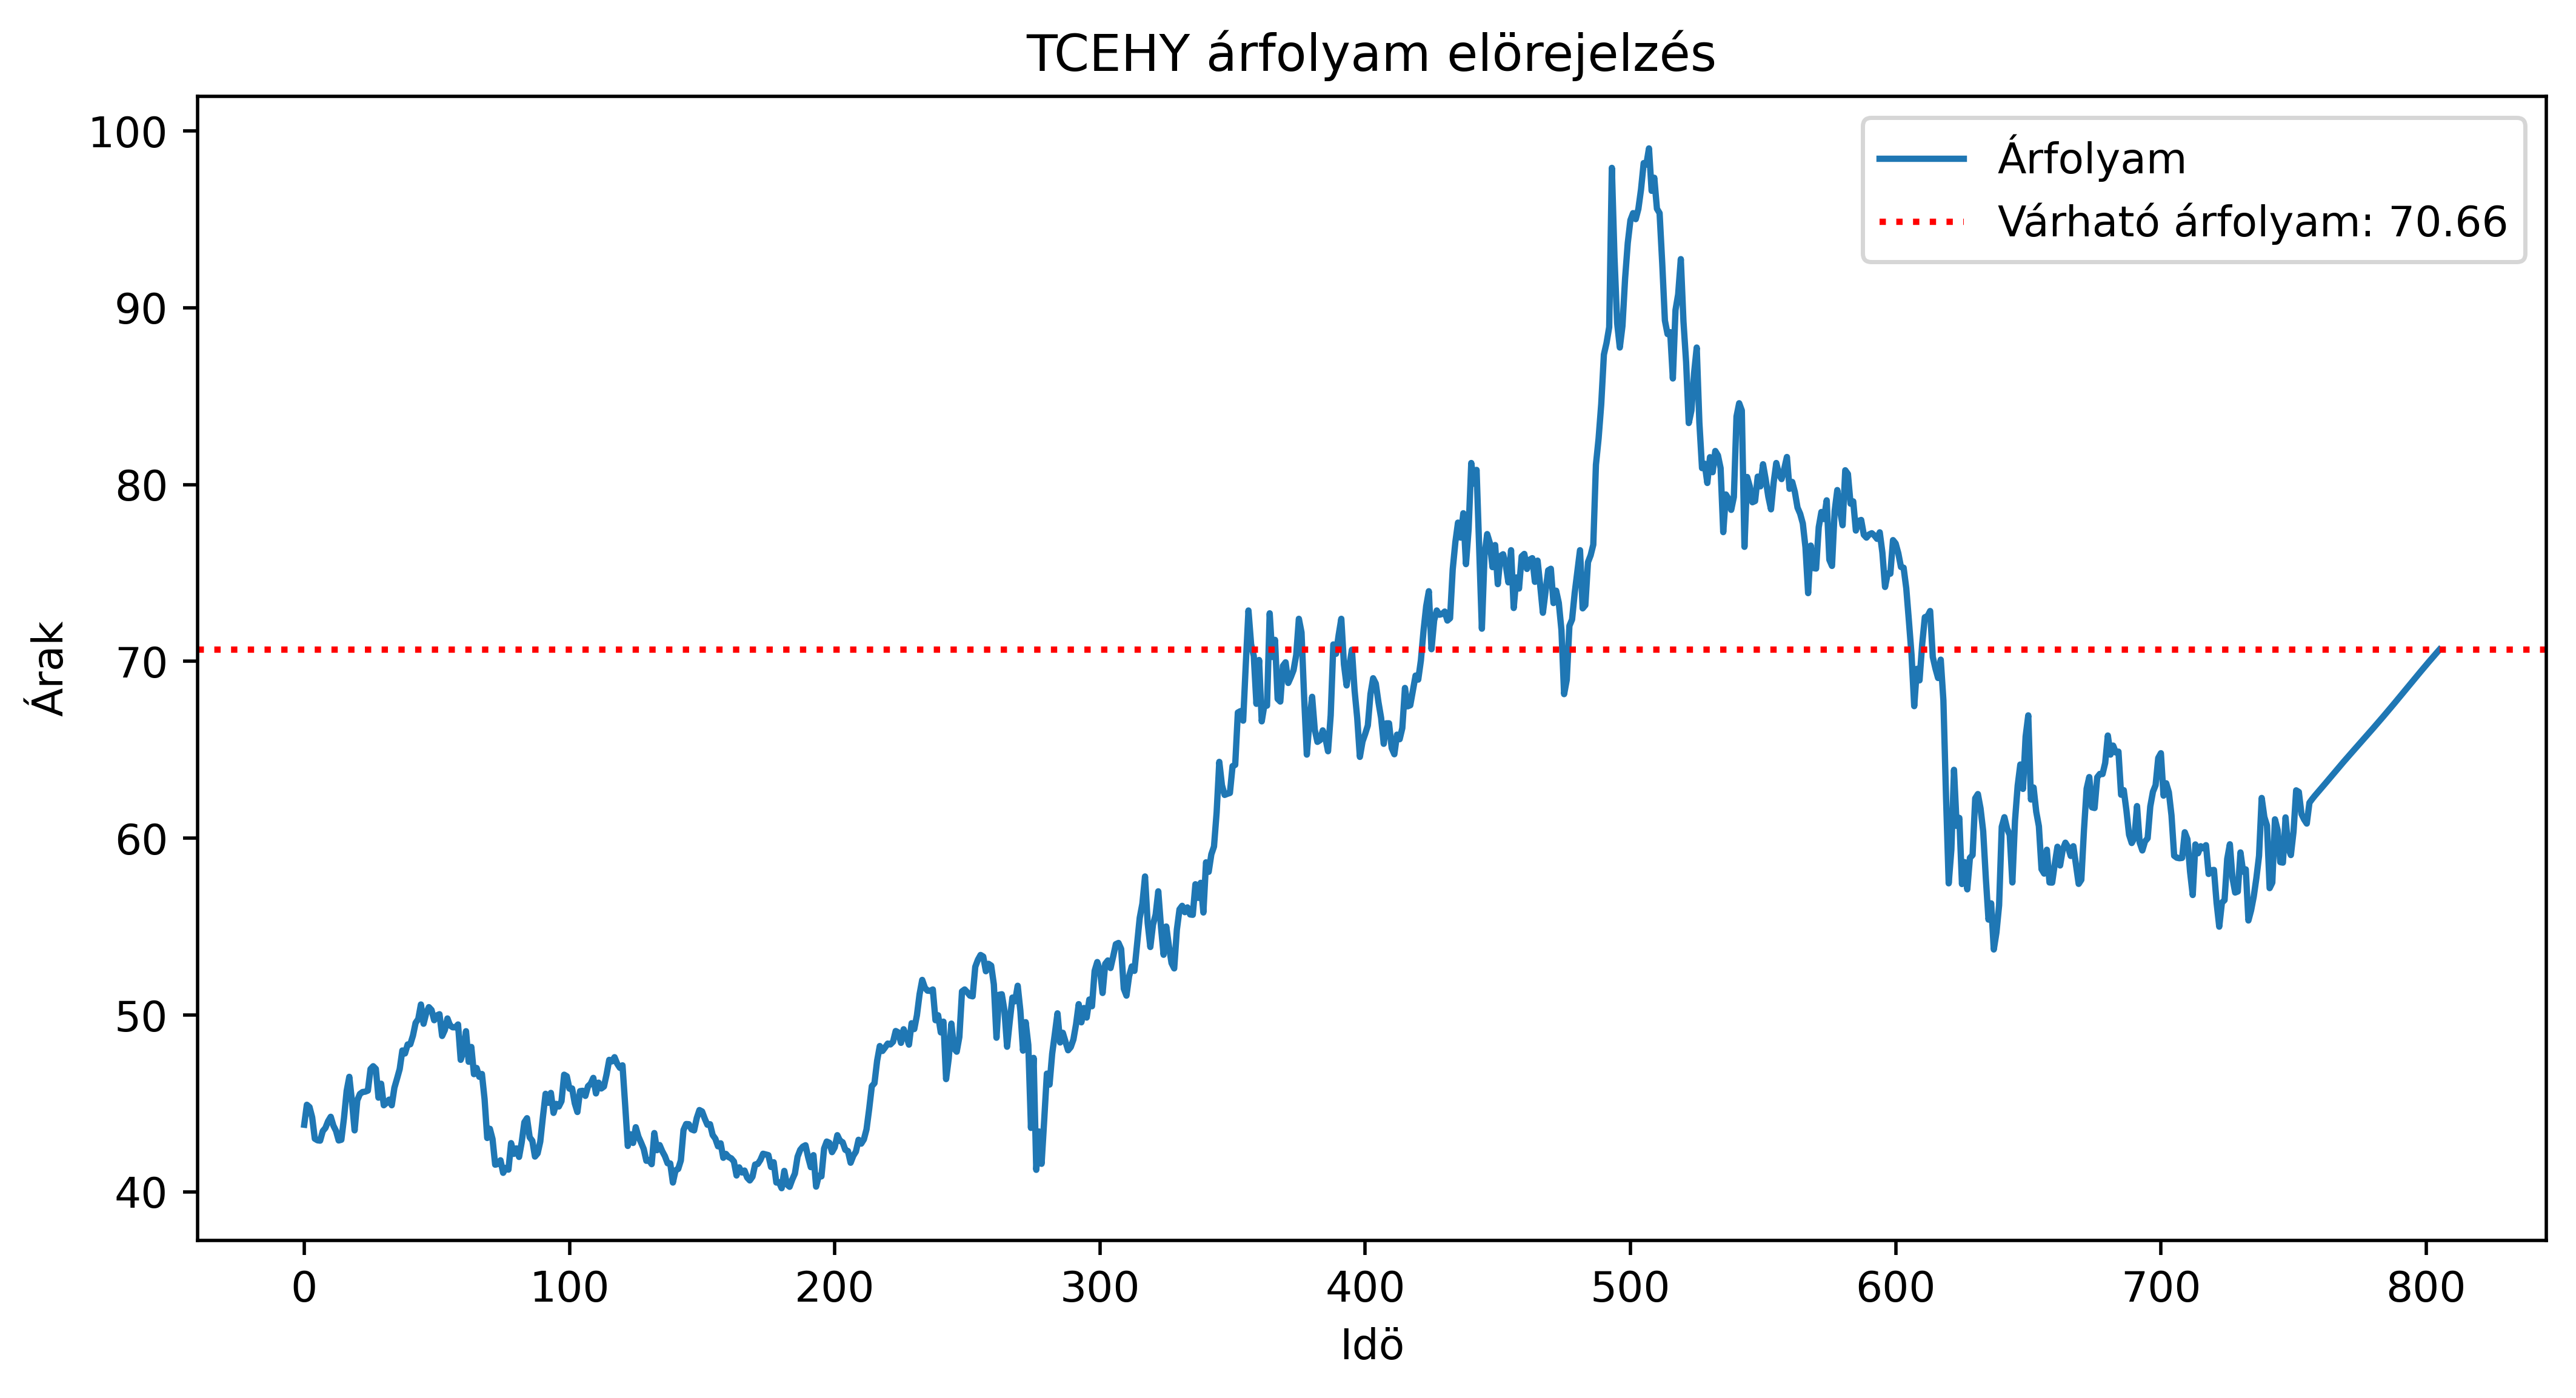

In [21]:
#Végső grafikon, adatok vissza transzformálása eredeti értékekre
final_graph = normalizalt.inverse_transform(uj_df).tolist()
print(normalizalt.inverse_transform(lst_er))
print(len(lst_er))


#Adatok megjelenitése
plt.figure(figsize=(10,5),dpi=500)
plt.plot(final_graph,label='Árfolyam')
plt.ylabel("Árak")
plt.xlabel("Idö")
plt.title("{0} árfolyam elörejelzés".format(szimbolum))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'Várható árfolyam: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()
